# Speech Emotion Recognition model Implementation using Deep Learning techniques

in this approach, we combine the several datasets like RAVDESS, CREMA-D, TESS and SAVEE to improve the dataset for training

Then we visualize the data distribution for each category and selected the 
- Neutral
- Happy
- Angry
- Sad
- Fear
- Disgust


Emotion categories for training. wth the help of data distribution, we balanced the dataset using over sampling techniques before training

After balancing the dataset, MFCC (Mel Frequency Cepstral Coefficients) and Mel Spectrogram features extracted for training purposes. for those features, we use data augmentation techniques to improve the generalization of the model.

CNN (convolutional neural network) used to build the emotion recognition model

In [1]:
!pip install pandas
!pip install numpy
!pip install librosa
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow
!pip install keras
!pip install audiomentations

  Using cached pandas-2.0.3-cp38-cp38-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.6 kB)
Using cached pandas-2.0.3-cp38-cp38-macosx_11_0_arm64.whl (10.7 MB)
Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl (13.8 MB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached librosa-0.10.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 586.2 kB/s eta 0:00:00 0:00:01
  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numba-0.58.1-cp38-cp38-macosx_11_0_arm64.whl.metadata (2.7 kB)
  Using cached soundfile-0.12.1-py2.py3-none-macosx_11_0_arm64.whl.metadata (14 kB)
  Using cached pooch-1.8.1-py3-none-any.whl.metadata (9.

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

from audiomentations import Compose, TimeStretch, PitchShift

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# datasets paths

Ravdess = "/Users/shenalfernando/Documents/FYP/Implementation/ravdess-dataset/"
Crema = "/Users/shenalfernando/Documents/FYP/Implementation/CREMA-D/"
Tess = "/Users/shenalfernando/Documents/FYP/Implementation/TESS/"
Savee = "/Users/shenalfernando/Documents/FYP/Implementation/SAVEE/"

In [4]:
# Constants
EMOTION_COL = "Emotions"
PATH_COL = "Path"

NEUTRAL = "neutral"
CALM = "calm"
HAPPY = "happy"
SAD = "sad"
ANGRY = "angry"
FEAR = "fear"
DISGUST = "disgust"
SURPRISE = "surprise"


ZCR = "ZCR"
CHROMA_STFT = "CHROMA_STFT"
MFCC = "MFCC"
RMS = "RMS"
MEL_SPECTROGRAM = "MEL_SPECTROGRAM"
TEAGER_ENERGY_MFCC = "TEAGER_ENERGY_MFCC"

## Helper function extract the emotion and path from ravdess dataset

This helper function is used to extract the emotion category and the speech file path and create a 
dataframe using these values (emotion - path)

Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) is a dataset that usually used for speech emotion recognition model implementations. Here we use a portion of the dataset for academic purposes. this portion contains 1440 files which are 12 male and 12 female actors vocalizing two lexically-matched statements in North American Accent. this contains calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Filename Identifiers
- Modality (01 = Full-AV, 02 = Video Only, 03 = Audio Only).
- Vocal Channel (01=speech, 02=song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav
1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)

In [5]:
# function to re-assemble the emotion with file_path in RAVDESS dataset
def assemble_ravdess_dataset(dataset_path):
    ravdess_dataset = os.listdir(dataset_path)
    emotions = []
    paths = []

    for directory in ravdess_dataset:
        actor_folder = os.listdir(dataset_path + directory)
        for file in actor_folder:
            file_name = file.split(".")[0]
            parts = file_name.split("-")
            emotions.append(int(parts[2]))  # get the emotion category according to the number present file name
            paths.append(dataset_path + directory + "/" + file)

    # data frame for emotions
    emotion_df = pd.DataFrame(emotions, columns=[EMOTION_COL])

    # data frame for paths
    path_df = pd.DataFrame(paths, columns=[PATH_COL])

    ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    ravdess_df.Emotions.replace({
        1: NEUTRAL,
        2: CALM,
        3: HAPPY,
        4: SAD,
        5: ANGRY,
        6: FEAR,
        7: DISGUST,
        8: SURPRISE
    }, inplace=True)

    return ravdess_df

## Helper function extract the emotion and path from crema-d dataset

This helper function is used to extract the emotion category and the speech file path and create a 
dataframe using these values (emotion - path)

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

Example File Name
1001_DFA_ANG_XX.wav
1001_IEO_ANG_HI.wav

In [6]:
# function to re-assemble the emotion with file_path in CREMA-D dataset
def assemble_crema_dataset(dataset_path):
    crema_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in crema_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')
        if parts[2] == 'SAD':
            emotions.append(SAD)
        elif parts[2] == 'ANG':
            emotions.append(ANGRY)
        elif parts[2] == 'DIS':
            emotions.append(DISGUST)
        elif parts[2] == 'FEA':
            emotions.append(FEAR)
        elif parts[2] == 'HAP':
            emotions.append(HAPPY)
        elif parts[2] == 'NEU':
            emotions.append(NEUTRAL)
        else:
            emotions.append('Unknown')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    crema_df = pd.concat([emotions_df, paths_df], axis=1)
    return crema_df

## Helper function extract emotion and the path from tess dataset

There are a set of 200 target words were spoken in the carrier phrase "Say the word _' by two actresses (aged 26 and 64 years) and recordings were made of the set portraying each of seven emotions (anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral). There are 2800 data points (audio files) in total.

Example Filename
OAF_back_fear.wav

In [7]:
# function to re-assemble the emotion with file_path in TESS dataset
def assemble_tess_dataset(dataset_path):
    tess_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for directory in tess_dataset:
        directories = os.listdir(dataset_path + directory)
        for file in directories:
            file_name = file.split('.')[0]
            emotion = file_name.split('_')[2]
            if emotion == 'ps':
                emotions.append(SURPRISE)
            else:
                emotions.append(emotion)
            paths.append(dataset_path + directory + "/" + file)

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    tess_df = pd.concat([emotions_df, paths_df], axis=1)
    return tess_df

## Helper function to extract emotion and path from the SAVEE dataset

The SAVEE database was recorded from four native English male speakers (identified as DC, JE, JK, KL), postgraduate students and researchers at the University of Surrey aged from 27 to 31 years. Emotion has been described psychologically in discrete categories: anger, disgust, fear, happiness, sadness and surprise. A neutral category is also added to provide recordings of 7 emotion categories.

Example Filename
DC_a06.wav

In [8]:
# function to re-assemble the emotion with file_path in SAVEE dataset
def assemble_savee_dataset(dataset_path):
    savee_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in savee_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')[1]
        emotion = parts[:-6]
        if emotion == 'a':
            emotions.append('angry')
        elif emotion == 'd':
            emotions.append('disgust')
        elif emotion == 'f':
            emotions.append('fear')
        elif emotion == 'h':
            emotions.append('happy')
        elif emotion == 'n':
            emotions.append('neutral')
        elif emotion == 'sa':
            emotions.append('sad')
        else:
            emotions.append('surprise')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    savee_df = pd.concat([emotions_df, paths_df], axis=1)
    return savee_df

## Some Helper functions for data preprocessing and visualization

In [44]:
# to combine several dataframes. Ex: Ravdess + Crema + Tess + Savee
def combine_dataframes(dataframes):
    emotions_dataset = pd.concat(dataframes, axis=0)
    emotions_dataset.to_csv("data_path.csv", index=False)

    return emotions_dataset


# to visualize the dataframe
def visualize_dataset(dataset_path, title, x_label, y_label):
    plt.title(title, size=16)
    sns.countplot(dataset_path, x=EMOTION_COL)
    plt.xlabel(x_label, size=12)
    plt.ylabel(y_label, size=12)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.show()
    

# to visualize the wave    
def display_wave(data, sample_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Wave for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()
    

# to visualize the losses
def visualize_training(epochs, history):
    num_of_epochs = [i for i in range(epochs)]
    figure, ax = plt.subplots(1,2)
    training_accuracy = history.history['accuracy']
    training_loss = history.history['loss']
    testing_accuracy = history.history['val_accuracy']
    testing_loss = history.history['val_loss']
    
    figure.set_size_inches(40, 12)
    
    ax[0].plot(num_of_epochs, training_loss, label='Training Loss')
    ax[0].plot(num_of_epochs, testing_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    
    ax[1].plot(num_of_epochs, training_accuracy, label='Training Accuracy')
    ax[1].plot(num_of_epochs, testing_accuracy, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    
    plt.show()
    
    
# visualize the confusion matrix report
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidths=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()
    
# to visualize the spectrogram    
def display_spectrogram(data, sample_rate, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    librosa.display.specshow(xdb, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

## Data Augmentation techniques for speech emotion recognition

In [10]:
# data augmentation using audiomentations
def signal_augmentation_pitch_shift(signal, sample_rate):
    augment = Compose([
        PitchShift(min_semitones=-8, max_semitones=8, p=1)
    ])
    
    augmented_signal = augment(signal, sample_rate)
    return augmented_signal


def signal_augmentation_time_stretch(signal, sample_rate):
    augment = Compose([
        TimeStretch(min_rate=0.8, max_rate=1.2, leave_length_unchanged=False, p=1)
    ])
    
    augmented_signal = augment(signal, sample_rate)
    return augmented_signal

## feature extraction helper functions

In [11]:
# extract zero cross rate feature
def extract_zcr_feature(data):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    return zcr


# extract Chroma_stft
def extract_chroma_stft(data, sample_rate):
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    return chroma_stft



# extract MFCC
def extract_mfcc(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc


# extract Root Mean Square Value
def extract_rms(data):
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    return rms


# extract mel spectrogram
def extract_mel_spectrogram(data, sample_rate):
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    return mel_spectrogram


# Teager Energy Based MFCC feature
def extract_teager_energy_mfcc(data, sample_rate):
    teager_energy = librosa.effects.preemphasis(data)
    teager_mfcc = np.mean(librosa.feature.mfcc(y=teager_energy, sr=sample_rate).T, axis=0)
    return teager_mfcc

## feature combine helper functions

In [12]:
# feature combinations
def extract_features(features, signal, sample_rate):
    result = np.array([])
    
    if ZCR in features:
        zcr = extract_zcr_feature(signal)
        result = np.hstack((result, zcr))
        
    if CHROMA_STFT in features:
        chroma_stft = extract_chroma_stft(signal, sample_rate)
        result = np.hstack((result, chroma_stft))
    
    if MFCC in features:
        mfcc_features = extract_mfcc(signal, sample_rate)
        result = np.hstack((result, mfcc_features))
        
    if RMS in features:
        rms = extract_rms(signal)
        result = np.hstack((result, rms))
        
    if MEL_SPECTROGRAM in features:
        mel_spectrogram = extract_mel_spectrogram(signal, sample_rate)
        result = np.hstack((result, mel_spectrogram))
        
    return result


# feature combination for SER
def combine_features(path):
  signal, sample_rate = librosa.load(path)

  # without augmentation
  pure_result = extract_features([MFCC, MEL_SPECTROGRAM], signal, sample_rate)
  result = np.array(pure_result)

  pitch_shift_signal = signal_augmentation_pitch_shift(signal, sample_rate)
  pitch_shift_result = extract_features([MFCC, MEL_SPECTROGRAM], pitch_shift_signal, sample_rate)
  result = np.vstack((result, pitch_shift_result))
  
  time_stretch_signal = signal_augmentation_time_stretch(signal, sample_rate)
  time_stretch_result = extract_features([MFCC, MEL_SPECTROGRAM], time_stretch_signal, sample_rate)
  result = np.vstack((result, time_stretch_result))

  return result

## CNN Model Implementation for Speech Emotion Recognition

In [34]:
def create_cnn_model(input_shape, filters, kernel_size, dropout):
    model = Sequential()
    
    model.add(Conv1D(filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters * 4, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='softmax'))
    
    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    
    return model

## re-assembled dataframes for each dataset

In [14]:
ravdess_df = assemble_ravdess_dataset(Ravdess)
ravdess_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,fear,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,angry,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


In [15]:
crema_df = assemble_crema_dataset(Crema)
crema_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,angry,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


In [16]:
tess_df = assemble_tess_dataset(Tess)
tess_df.head()

,Emotions,Path
0,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
1,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
2,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
3,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


In [17]:
savee_df = assemble_savee_dataset(Savee)
savee_df.head()

,Emotions,Path
0,sad,/Users/shenalfernando/Documents/FYP/Implementa...
1,sad,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,surprise,/Users/shenalfernando/Documents/FYP/Implementa...
4,neutral,/Users/shenalfernando/Documents/FYP/Implementa...


In [18]:
# combining all the data
emotion_dataframes = combine_dataframes([ravdess_df, crema_df, tess_df, savee_df])
emotion_dataframes.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,fear,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,angry,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


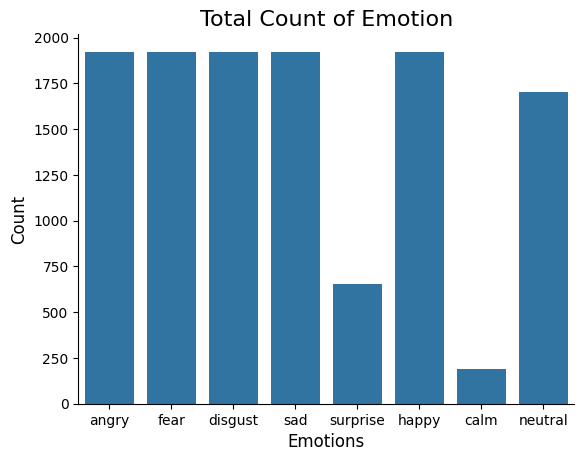

In [19]:
# visualizing the dataset
visualize_dataset(emotion_dataframes, 'Total Count of Emotion', 'Emotions', 'Count')

In [20]:
# analyze the dataset and balance the dataframe for training with oversampling
print("Emotion count for each category")
emotion_counts = emotion_dataframes.Emotions.value_counts()
print(emotion_counts)
print('-------------------------------------------')

print("Filtered emotion count for each category")
invalid_emotions = [SURPRISE, CALM]
filtered_df = emotion_dataframes[~emotion_dataframes[EMOTION_COL].isin(invalid_emotions)]
filtered_emotion_counts = filtered_df.Emotions.value_counts()
print(filtered_emotion_counts)
print('-------------------------------------------')

max_emotion_count = filtered_emotion_counts.max()
print(max_emotion_count)

# oversampling process
emotions_to_oversample = [NEUTRAL]

oversample_data = []

for emotion in emotions_to_oversample:
    oversampled_row = filtered_df[filtered_df[EMOTION_COL] == emotion].sample(max_emotion_count - emotion_counts[emotion], replace=True)
    oversample_data.append(oversampled_row)

print("Balanced emotion count for each category")
balanced_data_oversample = pd.concat([filtered_df] + oversample_data)
balanced_data_count = balanced_data_oversample.Emotions.value_counts()
print(balanced_data_count)

Emotion count for each category
Emotions
angry       1923
fear        1923
disgust     1923
sad         1923
happy       1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64
-------------------------------------------
Filtered emotion count for each category
Emotions
angry      1923
fear       1923
disgust    1923
sad        1923
happy      1923
neutral    1703
Name: count, dtype: int64
-------------------------------------------
1923
Balanced emotion count for each category
Emotions
angry      1923
fear       1923
disgust    1923
sad        1923
happy      1923
neutral    1923
Name: count, dtype: int64


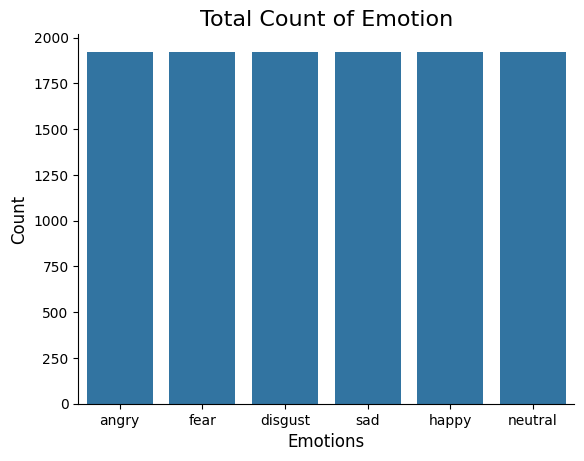

In [21]:
# visualize the balanced dataset
visualize_dataset(balanced_data_oversample, 'Total Count of Emotion', 'Emotions', 'Count')

In [22]:
# get all features using over sampling data
X, Y = [], []
for path, emotion in zip(balanced_data_oversample.Path, balanced_data_oversample.Emotions):
    features = combine_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)

print('Feature extraction and combination is success')

Feature extraction and combination is success


In [24]:
len(X), len(Y), balanced_data_oversample.Path.shape

(34614, 34614, (11538,))

In [25]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('emotion_features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,labels
0,-542.260559,33.782993,-3.803620,3.091988,-9.681703,-6.023736,-8.644806,-11.424563,-11.615019,-1.289247,...,4.270245e-03,2.580150e-03,3.102504e-03,2.955016e-03,3.657512e-03,3.838751e-03,3.899830e-03,3.291206e-03,1.600879e-04,angry
1,-570.159729,30.117447,-7.453498,-2.850819,-14.895274,-8.587306,-14.607397,-13.201256,-5.196628,-2.455241,...,1.703547e-03,1.522209e-03,2.519582e-03,3.101818e-03,4.853127e-03,3.602354e-03,2.122099e-03,6.534071e-04,3.202234e-05,angry
2,-577.448364,34.654255,-4.908528,1.294168,-11.147126,-6.210771,-9.283228,-12.457656,-12.527025,-0.288357,...,1.712110e-03,1.197323e-03,1.221456e-03,9.838165e-04,1.504003e-03,1.655294e-03,1.661395e-03,1.403580e-03,6.657085e-05,angry
3,-550.819153,37.232445,-5.966861,4.732355,-2.008577,-9.404687,-14.451254,-14.265598,-8.414462,0.758801,...,1.824054e-03,2.069973e-03,2.700931e-03,2.211849e-03,2.078804e-03,1.813579e-03,1.936400e-03,1.159482e-03,8.035084e-05,fear
4,-576.079102,56.723660,-13.233316,15.551181,-7.347561,10.781767,-8.620719,-1.634438,-14.533536,-16.820402,...,2.571960e-15,2.386258e-15,1.163291e-15,1.013872e-15,9.230364e-16,8.444156e-16,8.136342e-16,7.685942e-16,7.443453e-16,fear


In [27]:
emotion_df = pd.read_csv('emotion_features.csv')
labels = emotion_df['labels']
label_mapping = {
    'angry': 0,
    'fear': 1,
    'disgust': 2,
    'sad': 3,
    'happy': 4,
    'neutral': 5
}

numerical_labels = labels.map(label_mapping)
emotion_df['labels'] = numerical_labels
emotion_df.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,labels
0,-542.260559,33.782993,-3.803620,3.091988,-9.681703,-6.023736,-8.644806,-11.424563,-11.615019,-1.289247,...,4.270245e-03,2.580150e-03,3.102504e-03,2.955016e-03,3.657512e-03,3.838751e-03,3.899830e-03,3.291206e-03,1.600879e-04,0
1,-570.159729,30.117447,-7.453498,-2.850819,-14.895274,-8.587306,-14.607397,-13.201256,-5.196628,-2.455241,...,1.703547e-03,1.522209e-03,2.519582e-03,3.101818e-03,4.853127e-03,3.602354e-03,2.122099e-03,6.534071e-04,3.202234e-05,0
2,-577.448364,34.654255,-4.908528,1.294168,-11.147126,-6.210771,-9.283228,-12.457656,-12.527025,-0.288357,...,1.712110e-03,1.197323e-03,1.221456e-03,9.838165e-04,1.504003e-03,1.655294e-03,1.661395e-03,1.403580e-03,6.657085e-05,0
3,-550.819153,37.232445,-5.966861,4.732355,-2.008577,-9.404687,-14.451254,-14.265598,-8.414462,0.758801,...,1.824054e-03,2.069973e-03,2.700931e-03,2.211849e-03,2.078804e-03,1.813579e-03,1.936400e-03,1.159482e-03,8.035084e-05,1
4,-576.079102,56.723660,-13.233316,15.551181,-7.347561,10.781767,-8.620719,-1.634438,-14.533536,-16.820402,...,2.571960e-15,2.386258e-15,1.163291e-15,1.013872e-15,9.230364e-16,8.444156e-16,8.136342e-16,7.685942e-16,7.443453e-16,1


In [28]:
X = emotion_df.iloc[: ,:-1].values
Y = emotion_df['labels'].values

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25960, 148), (25960,), (8654, 148), (8654,))

In [30]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25960, 148), (25960,), (8654, 148), (8654,))

In [31]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25960, 148, 1), (25960,), (8654, 148, 1), (8654,))

In [35]:
ser_model = create_cnn_model((148,1), 112, 4, 0.3)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
ser_model_16_history = ser_model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
812/812 [==============================] - 18s 22ms/step - loss: 1.3721 - accuracy: 0.4375 - val_loss: 1.1972 - val_accuracy: 0.5109 - lr: 0.0010
Epoch 2/50
812/812 [==============================] - 18s 22ms/step - loss: 1.1569 - accuracy: 0.5346 - val_loss: 1.1098 - val_accuracy: 0.5615 - lr: 0.0010
Epoch 3/50
812/812 [==============================] - 18s 22ms/step - loss: 1.0585 - accuracy: 0.5789 - val_loss: 1.0672 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 4/50
812/812 [==============================] - 19s 23ms/step - loss: 0.9787 - accuracy: 0.6154 - val_loss: 1.0272 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 5/50
812/812 [==============================] - 20s 24ms/step - loss: 0.9027 - accuracy: 0.6445 - val_loss: 0.9988 - val_accuracy: 0.6079 - lr: 0.0010
Epoch 6/50
812/812 [==============================] - 19s 24ms/step - loss: 0.8226 - accuracy: 0.6750 - val_loss: 1.0012 - val_accuracy: 0.6208 - lr: 0.0010
Epoch 7/50
812/812 [==============================] - 20s 

In [36]:
print("Accuracy of model on test data : ", ser_model.evaluate(x_test, y_test)[1] * 100, "%")

271/271 [==============================] - 2s 7ms/step - loss: 3.0257 - accuracy: 0.7241
Accuracy of model on test data :  72.4058210849762 %


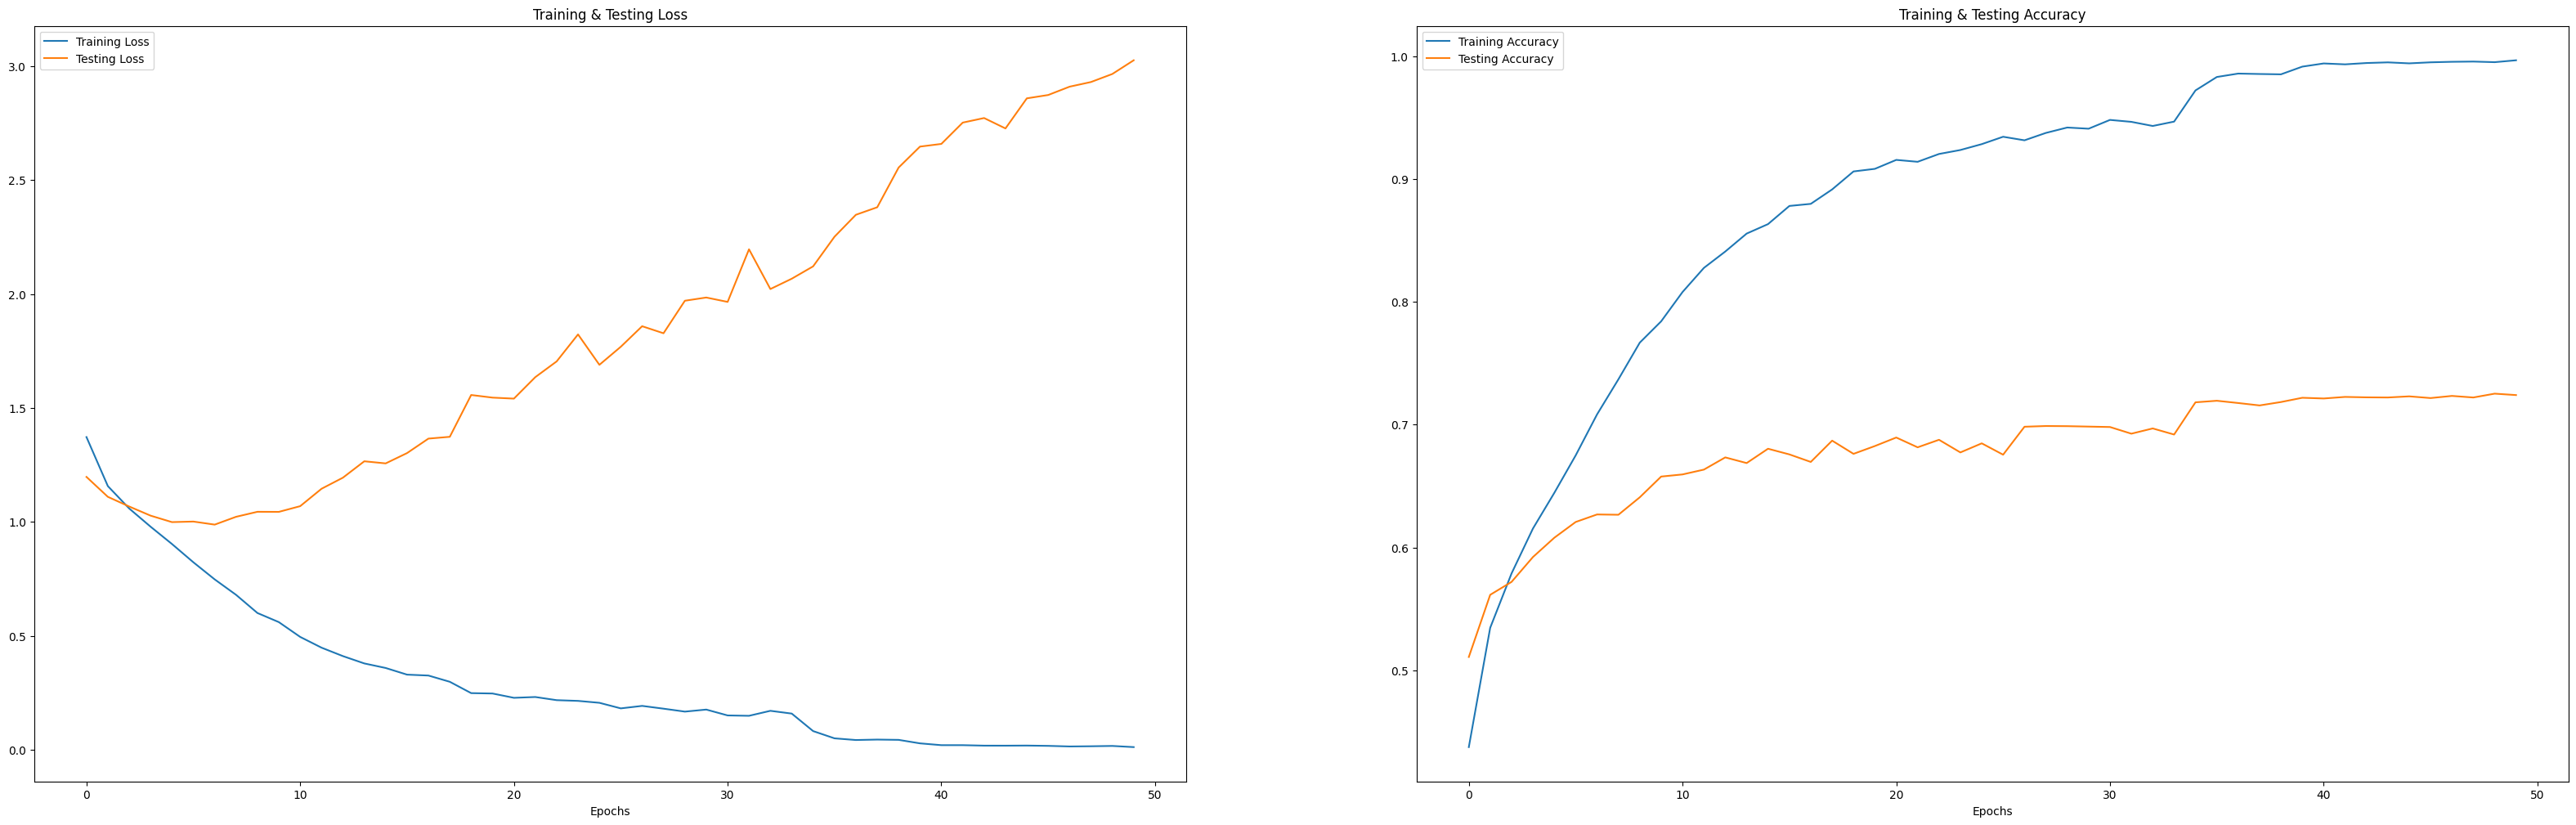

In [37]:
visualize_training(50, ser_model_16_history)

In [38]:
pred_test = ser_model.predict(x_test)
pred_test[1]

271/271 [==============================] - 2s 7ms/step


array([1.0262584e-06, 5.6190449e-03, 6.5128498e-02, 1.3889777e-21,
       9.2925143e-01, 3.6916425e-16], dtype=float32)

In [39]:
np.argmax(pred_test[1])

4

In [40]:
ser_model.save('ser-model.h5')

In [41]:
predicted_labels = [np.argmax(i) for i in pred_test]
predicted_labels[:5]

[2, 4, 0, 2, 0]

In [43]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = predicted_labels
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,2,2
1,4,1
2,0,0
3,2,2
4,0,0
5,3,3
6,5,3
7,2,2
8,0,0
9,5,5


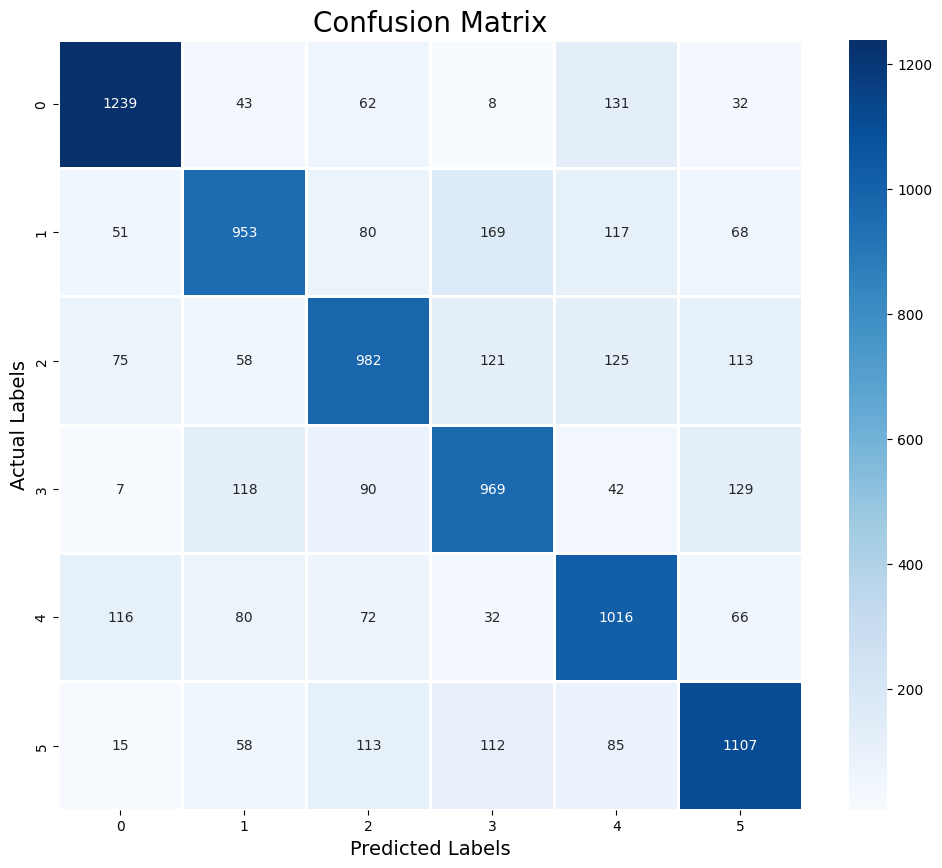

In [45]:
display_confusion_matrix(y_test,predicted_labels)

In [46]:
print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1515
           1       0.73      0.66      0.69      1438
           2       0.70      0.67      0.68      1474
           3       0.69      0.72      0.70      1355
           4       0.67      0.74      0.70      1382
           5       0.73      0.74      0.74      1490

    accuracy                           0.72      8654
   macro avg       0.72      0.72      0.72      8654
weighted avg       0.73      0.72      0.72      8654

